<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/lidc_transfer_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ERM CNN Model for Malignancy

#First We setup the repo

In [1]:
# Only run if on Colab
#%cd .. #run this on local machine
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3343, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 3343 (delta 258), reused 349 (delta 205), pack-reused 2925
Receiving objects: 100% (3343/3343), 56.13 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (3070/3070), done.
Checking out files: 100% (5393/5393), done.
/content/LIDC_GDRO


In [ ]:
# !git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/mtzig/LIDC_GDRO
   3c921ee..758af5a  main       -> origin/main
Updating 3c921ee..758af5a
Fast-forward
 image_data_utils.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import VGGNet, ResNet18
from loss import ERMLoss, GDROLossAlt, GDROLoss
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision

In [4]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


#Test Models

In [5]:
import torch.nn as nn

class testModel(nn.Module):

    def __init__(self, device='cpu', pretrained=True, freeze=True):
        super(testModel, self).__init__()

        self.model = torchvision.models.resnet18(pretrained=pretrained).to(device) #torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


            # for param in self.model.layer4.parameters():
            #     param.requires_grad = True

        self.model.fc = nn.Sequential(
          nn.Linear(in_features=512, out_features=36, bias=True, device=device),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=36, out_features=2, bias=True, device=device)
          # nn.Linear(in_features=36, out_features=1, bias=True, device=device)
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()


#Next We get our data

## Now we get the data

In [6]:
from image_data_utils import getImages, getTrainValSplit, getSubtypedDataLoader

In [8]:
train_data, test_data = getImages(device=DEVICE)

train_split = SubclassedNoduleDataset(*train_data)

test_set = SubclassedNoduleDataset(*test_data)
train_set, val_set = getTrainValSplit(train_split, split_percent = 0.95)

In [ ]:
# train_loader = getSubtypedDataLoader(train_set,5)

In [9]:
val_loader = InfiniteDataLoader(val_set, len(val_set))
test_loader = InfiniteDataLoader(test_set, len(test_set))

In [10]:
train_loader = InfiniteDataLoader(train_set, 128)

#Now we create the model and setup training

First we make our model

In [ ]:
model = testModel(device=DEVICE, pretrained=True, freeze=False)

In [ ]:
# loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
# loss_fn = GDROLoss(model,torch.nn.CrossEntropyLoss(),{'groupdro_eta':0.01}, )
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)

loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.1, 4) 
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)

# loss_fn = ERMLoss(model,torch.nn.functional.binary_cross_entropy_with_logits,{})


We also make learning rate scheduler

In [ ]:
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

##Now we train the model

In [ ]:
epochs = 15#40
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    accuracies = test(val_loader, model, verbose=True)
    scheduler.step(min(accuracies[1:]))

Epoch 1/15
Average training loss: 0.8673823841593482
Accuracy: 0.7491749174917491 
Accuracy over subgroups: [0.33333333 0.60135135 0.97826087 0.8627451 ] 
Worst Group Accuracy: 0.3333333333333333
Epoch 2/15
Average training loss: 0.483043645593253
Accuracy: 0.7722772277227723 
Accuracy over subgroups: [0.3        0.71875    0.91358025 0.80769231] 
Worst Group Accuracy: 0.3
Epoch 3/15
Average training loss: 0.42489313605156814
Accuracy: 0.7392739273927392 
Accuracy over subgroups: [0.38095238 0.7983871  0.79775281 0.66666667] 
Worst Group Accuracy: 0.38095238095238093
Epoch 4/15
Average training loss: 0.3468688147311861
Accuracy: 0.7491749174917491 
Accuracy over subgroups: [0.5        0.81081081 0.73076923 0.68253968] 
Worst Group Accuracy: 0.5
Epoch 5/15
Average training loss: 0.26301669668067584
Accuracy: 0.8052805280528053 
Accuracy over subgroups: [0.77272727 0.88028169 0.84146341 0.57894737] 
Worst Group Accuracy: 0.5789473684210527
Epoch 6/15
Average training loss: 0.224936500530

#Lastly We evaluate model performance

##Model Performance on Test Set

In [ ]:
#spaghetti code-esque way to get imgs and labels for entire test set
accuracies = test(test_loader, model, verbose=False)

print(f'spiculated benign accuracy: {accuracies[1]:.3f}')
print(f'unspiculated benign accuracy: {accuracies[2]:.3f}')
print(f'spiculated malignant accuracy: {accuracies[3]:.3f}')
print(f'unspiculated malignant accuracy: {accuracies[4]:.3f}')

print(f'Total accuracy: {accuracies[0]:.3f}')

spiculated benign accuracy: 0.905
unspiculated benign accuracy: 0.869
spiculated malignant accuracy: 0.941
unspiculated malignant accuracy: 0.778
Total accuracy: 0.882


##saving model for gdro

In [ ]:
weight_path = os.path.join('/content', 'LIDC_GDRO', 'weights')
# torch.save(model.state_dict(), weight_path) #saves weights in file called weights

In [ ]:
model = testModel(device=DEVICE, pretrained=False, freeze=True) #model with gradients frozen 
model.load_state_dict(torch.load(weight_path, map_location="cuda:0")) #loads it in
model.model.fc = nn.Sequential(
        nn.Linear(in_features=512, out_features=36, bias=True, device=DEVICE),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5, inplace=False),
        # nn.Linear(in_features=36, out_features=36, bias=True, device=DEVICE),
        # nn.ReLU(inplace=True),
        # nn.Dropout(p=0.5, inplace=False),
        nn.Linear(in_features=36, out_features=2, bias=True, device=DEVICE)
        # nn.Linear(in_features=36, out_features=1, bias=True, device=device)
      )

for layer in model.model.fc:
  if hasattr(layer, 'weight'):
    nn.init.xavier_uniform_(layer.weight)

In [ ]:
loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),1, 4) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)#lr=0.001, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

# Run of 30 test

In [19]:
all_accuracies = []
runs = 50
for run in range(runs):
  print(f'Run {run+1}/{runs}')
  model = testModel(device=DEVICE, pretrained=True, freeze=False)

  loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
  
  epochs = 15#40
  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    accuracies = test(val_loader, model, verbose=True)
    scheduler.step(min(accuracies[1:]))

  accuracies = test(test_loader, model, verbose=False)


  print(f'spiculated benign accuracy: {accuracies[1]:.3f}')
  print(f'unspiculated benign accuracy: {accuracies[2]:.3f}')
  print(f'spiculated malignant accuracy: {accuracies[3]:.3f}')
  print(f'unspiculated malignant accuracy: {accuracies[4]:.3f}')

  print(f'Total accuracy: {accuracies[0]:.3f}')
  all_accuracies.append(accuracies)

Run 1/50
Epoch 1/15
Average training loss: 0.609168606725606
Accuracy: 0.8745874587458746 
Accuracy over subgroups: [0.75       0.96376812 0.97802198 0.51851852] 
Worst Group Accuracy: 0.5185185185185185
Epoch 2/15
Average training loss: 0.3243803395466371
Accuracy: 0.8613861386138614 
Accuracy over subgroups: [0.84       0.90441176 0.9382716  0.67213115] 
Worst Group Accuracy: 0.6721311475409836
Epoch 3/15
Average training loss: 0.2513208243657242
Accuracy: 0.8547854785478548 
Accuracy over subgroups: [0.76190476 0.81632653 0.9625     0.83636364] 
Worst Group Accuracy: 0.7619047619047619
Epoch 4/15
Average training loss: 0.22844549708745696
Accuracy: 0.8382838283828383 
Accuracy over subgroups: [0.7037037  0.91428571 0.83116883 0.72881356] 
Worst Group Accuracy: 0.7037037037037037
Epoch 5/15
Average training loss: 0.2053403165191412
Accuracy: 0.7557755775577558 
Accuracy over subgroups: [0.94444444 0.96       0.66666667 0.42622951] 
Worst Group Accuracy: 0.4262295081967213
Epoch 6/15


In [27]:
total_acc = list(map(lambda x:x[0], all_accuracies))

In [28]:
sum(total_acc)/len(total_acc)

0.8323934426229508

In [33]:
accuracies = list(map(lambda x:(float(i) for i in x), all_accuracies))

In [34]:
df_ERM = pd.DataFrame(accuracies, columns = ['entire','marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant'])

In [35]:
df_ERM.head()

,entire,marked_benign,unmarked_benign,marked_malignant,unmarked_malignant
0,0.849180,0.736842,0.913669,0.876404,0.689655
1,0.822951,0.588235,0.827338,0.868132,0.810345
2,0.773770,0.793103,0.772414,0.835616,0.689655
3,0.845902,0.764706,0.836735,0.912500,0.803279
4,0.868852,0.842105,0.910345,0.883721,0.745455


In [36]:
df_ERM.to_csv('cnn_erm_accuracies.csv')

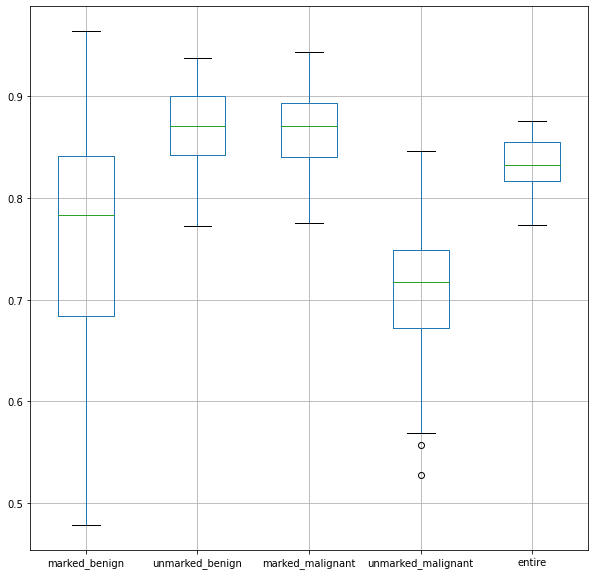

In [37]:
boxplot = df_ERM.boxplot(column=['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'], figsize = (10,10))  

#GDRO Model Performance

In [12]:
all_accuracies = []
runs = 50
for run in range(runs):
  print(f'Run {run+1}/{runs}')
  model = testModel(device=DEVICE, pretrained=True, freeze=False)

  loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.1,4)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
  
  epochs = 15#40
  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(train_loader, model, loss_fn, optimizer, verbose=True)
    accuracies = test(val_loader, model, verbose=True)
    scheduler.step(min(accuracies[1:]))

  accuracies = test(test_loader, model, verbose=False)


  print(f'spiculated benign accuracy: {accuracies[1]:.3f}')
  print(f'unspiculated benign accuracy: {accuracies[2]:.3f}')
  print(f'spiculated malignant accuracy: {accuracies[3]:.3f}')
  print(f'unspiculated malignant accuracy: {accuracies[4]:.3f}')

  print(f'Total accuracy: {accuracies[0]:.3f}')
  all_accuracies.append(accuracies)

Rn 1/50
Epoch 1/15
Average training loss: 0.8469913649288091
Accuracy: 0.768976897689769 
Accuracy over subgroups: [0.68421053 0.81954887 0.76699029 0.66666667] 
Worst Group Accuracy: 0.6666666666666666
Epoch 2/15
Average training loss: 0.47756104645403946
Accuracy: 0.759075907590759 
Accuracy over subgroups: [0.5        0.8        0.83146067 0.609375  ] 
Worst Group Accuracy: 0.5
Epoch 3/15
Average training loss: 0.39187201247973874
Accuracy: 0.801980198019802 
Accuracy over subgroups: [0.76470588 0.87969925 0.80612245 0.61818182] 
Worst Group Accuracy: 0.6181818181818182
Epoch 4/15
Average training loss: 0.356447848406705
Accuracy: 0.7854785478547854 
Accuracy over subgroups: [0.8        0.92903226 0.63513514 0.55102041] 
Worst Group Accuracy: 0.5510204081632653
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Average training loss: 0.2618985677307302
Accuracy: 0.8382838283828383 
Accuracy over subgroups: [0.77272727 0.89705882 0.91397849 0.57692308] 
Worst Gr

In [13]:
total_acc = list(map(lambda x:x[0], all_accuracies))
sum(total_acc)/len(total_acc)

0.8272131147540983

In [14]:
accuracies = list(map(lambda x:(float(i) for i in x), all_accuracies))

In [15]:
df = pd.DataFrame(accuracies, columns = ['entire', 'marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant'])

In [16]:
df.head()

,entire,marked_benign,unmarked_benign,marked_malignant,unmarked_malignant
0,0.832787,0.791667,0.872180,0.895349,0.677419
1,0.855738,0.785714,0.892617,0.886076,0.734694
2,0.822951,0.764706,0.876812,0.791667,0.759259
3,0.800000,1.000000,0.813433,0.817204,0.666667
4,0.839344,0.850000,0.867550,0.862069,0.702128


In [18]:
df.to_csv('cnn_gdro_accuracies.csv')

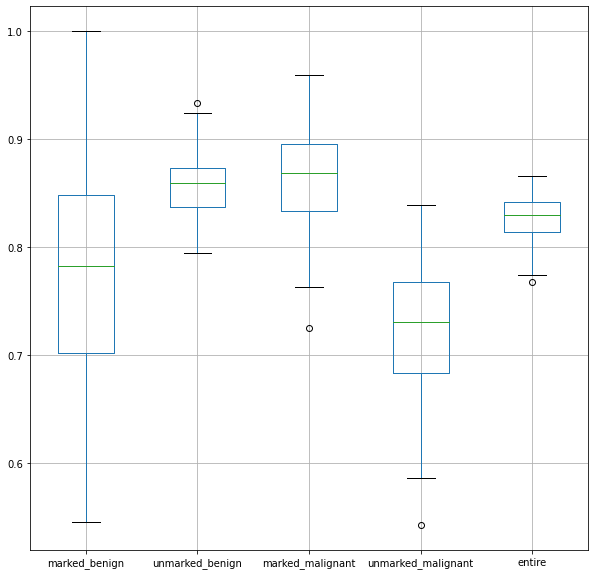

In [17]:
boxplot = df.boxplot(column=['marked_benign', 'unmarked_benign', 'marked_malignant', 'unmarked_malignant', 'entire'], figsize = (10,10))  